In [1]:
import keras
from keras.layers import Input, Dense, Concatenate
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, Flatten, Conv2D, MaxPooling1D, MaxPooling2D
from keras.optimizers import SGD
from keras import initializers
from keras.regularizers import l2

import player
import game
import neural_network
import mcts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import board as b
import keras
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import pandas as pd
import numpy as np
from copy import deepcopy

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# model = keras.models.load_model("./best_keras_model.tf")
data = pd.read_csv("training_data.csv")
data['empty_slots'] = data["init_state"].apply(lambda x: len(x) - len(x.replace(" ",""))) + abs(data["Value"])
data['weights'] = data["empty_slots"].apply(lambda x: pow(1.5, x))+5

X_str = data["init_state"].values
X_clean = np.array([b.Board.str2arr(x) for x in X_str])

Y_value = data["Value"].values
targets = (Y_value + 1).round()
Y_value_one_hot = np.eye(3)[targets.astype(int)]

In [ ]:
data.sort_values("weights")

In [3]:
data["Value"].value_counts()

 1    2936
-1    1474
 0    1068
Name: Value, dtype: int64

In [11]:

Input_1 = Input(shape=(3, 3, 1))

x1 = Conv2D(filters=3, kernel_size=(1, 3), activation='relu',
            kernel_regularizer=l2(0.005),
            kernel_initializer=initializers.RandomNormal(stddev=0.1, mean=0),
            input_shape=(3, 3, 1))(Input_1)

x2 = Conv2D(filters=3, kernel_size=(3, 1), activation='relu',
            kernel_regularizer=l2(0.005),
            kernel_initializer=initializers.RandomNormal(stddev=0.1, mean=0),
            input_shape=(3, 3, 1))(Input_1)

x3 = Conv2D(filters=20, kernel_size=(3, 3), activation='relu',
            kernel_regularizer=l2(0.005),
            kernel_initializer=initializers.RandomNormal(stddev=0.1, mean=0),
            input_shape=(3, 3, 1))(Input_1)

x1 = MaxPooling2D((3, 1))(x1)
x2 = MaxPooling2D((1, 3))(x2)
x3 = MaxPooling2D((1, 1))(x3)

x = Concatenate()([x1, x2, x3])
x = Flatten()(x)

value_head = Dense(100, activation='relu')(x)
value_head = Dense(10, activation='relu')(x)
value_head = Dense(1, activation='relu', name="V", use_bias=False)(x)

model = Model(inputs=Input_1, outputs=value_head)
model.compile(optimizer="adam",
                     loss= "mse",
                     metrics=['acc'])

model.save("./best_keras_model.tf")
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 3, 3, 1)]    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 3, 1, 3)      12          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 1, 3, 3)      12          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 1, 1, 20)     200         input_2[0][0]                    
____________________________________________________________________________________________

In [17]:
for i in range(10):
    sample = data.sample(4000,weights = data["weights"])

    X_str = sample["init_state"].values
    X_clean = np.array([b.Board.str2arr(x) for x in X_str])

    Y_value = sample["Value"].values

    X_final = np.stack([X_clean], axis=-1)
    Y_final  = (Y_value+1)/2
    model.fit(X_final, Y_final, epochs=10, verbose=1)

Train on 4000 samples
Epoch 1/10
4000/4000 [==============================] - 0s 71us/sample - loss: 0.3189 - acc: 0.4010
Epoch 2/10
4000/4000 [==============================] - 0s 68us/sample - loss: 0.1801 - acc: 0.5727
Epoch 3/10
4000/4000 [==============================] - 0s 88us/sample - loss: 0.1694 - acc: 0.5935
Epoch 4/10
4000/4000 [==============================] - 0s 56us/sample - loss: 0.1606 - acc: 0.6025
Epoch 5/10
4000/4000 [==============================] - 0s 55us/sample - loss: 0.1535 - acc: 0.6158
Epoch 6/10
4000/4000 [==============================] - 0s 53us/sample - loss: 0.1461 - acc: 0.6292
Epoch 7/10
4000/4000 [==============================] - 0s 65us/sample - loss: 0.1398 - acc: 0.6370
Epoch 8/10
4000/4000 [==============================] - 0s 59us/sample - loss: 0.1341 - acc: 0.6475
Epoch 9/10
4000/4000 [==============================] - 0s 58us/sample - loss: 0.1293 - acc: 0.6610
Epoch 10/10
4000/4000 [==============================] - 0s 48us/sample - loss

In [6]:
model.save("./best_keras_model.tf")

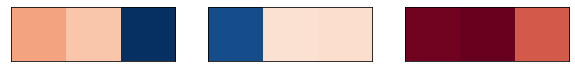

array([[0.01714338, 0.        , 0.19384448]], dtype=float32)

In [19]:
filters = model.layers[1].get_weights()[0]
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 3 , 1

fig, ax = plt.subplots(figsize=(10, 20))

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='RdBu', vmin = 0, vmax = 1)
        ix += 1

# show the figure
plt.show()
f[:, :, j]

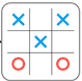

In [8]:
from IPython.display import Image
Image(filename='img.png')

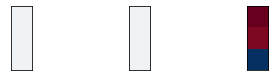

array([[0.        ],
       [0.03141775],
       [1.        ]], dtype=float32)

In [20]:
filters = model.layers[2].get_weights()[0]
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 3 , 1

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='RdBu', vmin = 0, vmax = 1)
        ix += 1

# show the figure
plt.show()
f[:, :, j]

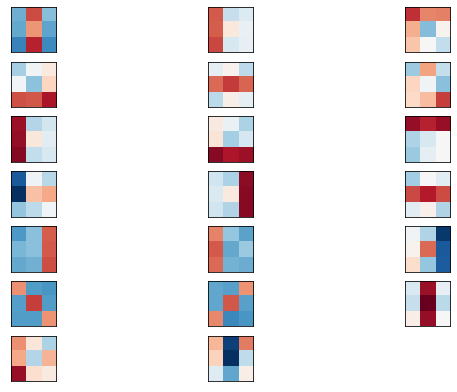

array([[0.33283684, 0.9662614 , 0.24157165],
       [0.38524592, 1.        , 0.62774825],
       [0.5662831 , 0.7608908 , 0.46661878]], dtype=float32)

In [21]:
filters = model.layers[3].get_weights()[0]
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 20, 1

fig, ax = plt.subplots(figsize=(10, 20))

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='RdBu', vmin = 0, vmax = 1)
        ix += 1

# show the figure


plt.show()

f[:, :, j]

In [ ]:
test = np.array([[ 1,  0,  1],
                 [ 1,  1,  -1],
                 [ -1,  -1,  -1]])


n_map = {-1:"o", 0: " ", 1: "x"}

str_state = ''.join([n_map[i] for i in test.reshape(9,)])
str_state
inp = np.stack([[test]], axis=-1)

pred = model.predict(inp)
print("x:",pred)
print("o:",(1-pred))

data[data["init_state"]==str_state]

In [ ]:
test = np.array([[ 1,  -1,  1],
                 [ 1,  1,  -1],
                 [ -1,  0,  -1]])


n_map = {-1:"o", 0: " ", 1: "x"}

str_state = ''.join([n_map[i] for i in test.reshape(9,)])
str_state
inp = np.stack([[test]], axis=-1)

pred = model.predict(inp)
print("x:",pred)
print("o:",(1-pred))

data[data["init_state"]==str_state]

In [ ]:
test = np.array([[ 1,  0,  0],
                 [ 0,  0, 0],
                 [ 0,  0, 0]])



n_map = {-1:"o", 0: " ", 1: "x"}

str_state = ''.join([n_map[i] for i in test.reshape(9,)])
str_state
inp = np.stack([[test]], axis=-1)

pred = model.predict(inp)
print("x:",pred)
print("o:",(1-pred))

data[data["init_state"]==str_state]

In [ ]:
test = np.array([[ 1,  0,  -1],
                 [ 0,  0, 0],
                 [ 0,  0, 0]])


n_map = {-1:"o", 0: " ", 1: "x"}

str_state = ''.join([n_map[i] for i in test.reshape(9,)])
str_state
inp = np.stack([[test]], axis=-1)

pred = model.predict(inp)
print("x:",pred)
print("o:",(1-pred))

data[data["init_state"]==str_state]

In [ ]:
test = np.array([[ 0,  0,  0],
                 [ 0,  -1, 0],
                 [ 0,  0, 1]])



n_map = {-1:"o", 0: " ", 1: "x"}

str_state = ''.join([n_map[i] for i in test.reshape(9,)])
str_state
inp = np.stack([[test]], axis=-1)

pred = model.predict(inp)
print("x:",pred)
print("o:",(1-pred))

data[data["init_state"]==str_state]

In [ ]:
test = np.array([[ 1,  1,  0],
                 [ -1,  -1, -1],
                 [ 0,  0, 1]])



n_map = {-1:"o", 0: " ", 1: "x"}

str_state = ''.join([n_map[i] for i in test.reshape(9,)])
str_state
inp = np.stack([[test]], axis=-1)

pred = model.predict(inp)
print("x:",pred)
print("o:",(1-pred))

data[data["init_state"]==str_state]

In [ ]:
test = np.array([[ 1,  1,  -1],
                 [ -1,  -1, 0],
                 [ 0,  0, 1]])



n_map = {-1:"o", 0: " ", 1: "x"}

str_state = ''.join([n_map[i] for i in test.reshape(9,)])
str_state
inp = np.stack([[test]], axis=-1)

pred = model.predict(inp)
print("x:",pred)
print("o:",(1-pred))

data[data["init_state"]==str_state]